# Trabalho de Banco de Dados - A2
## Análise de dados sobre a antropização de biomas extra-amazônicos 
> #### Alunos:
>
> Amanda de Mendonça Perez
>
> Julia Queiroz Delgado 
>
> Kenner Azevedo 

### Introdução:

Este trabalho tem como objetivo colocar em prática os conceitos estudados na disciplina de Banco de Dados, utilizando um banco de dados (no caso, foi escolhido o MongoDB) para armazenar dados geográficos do tipo `.geojson` e, a partir disso, realizar uma análise desses dados com o geopandas. A base escolhida foi sobre a [Antropização dos Biomas Extra-Amazônicos](https://dados.gov.br/dataset/antropizacao-dos-biomas-extra-amazonicos), que traz dados sobre a ação humana em biomas brasileiros. Além disso, os dados referentes ao Brasil, ou mais especificamente, aos seus contornos municipais, foi adquirido em <https://github.com/tbrugz/geodata-br>. Para a manipulação dos dados no banco, foi utilizado o `pymongo`, que permite trabalhar com dados em MongoDB pelo Python.

### O banco de dados

Primeiramente, foi necessário importar as bibloitecas que seriam utilizadas ao longo do trabalho. Em seguida, com `pymongo`, foi criado um banco de dados. Para que todos os integrantes do grupo pudessem acessá-lo, foi necessário que cada um criasse localmente o banco, reproduzindo o código a baixo, compartilhado entre os integrantes por meio deste notebook. 

In [25]:
#pip install -U -q pymongo

In [2]:
import datetime
import pprint

import pymongo
from pymongo import MongoClient

import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [3]:
#connect the database
client = MongoClient('localhost', 27017)
client.list_database_names()

['admin', 'bank', 'config', 'local']

In [4]:
db = client.bank

In [5]:
#ours collections
print(db.list_collection_names())
#we want insert data of states with format { "name" : Nome_estado , "valor" : val}

['data', 'states']


Após criado o banco, foram inseridos os dados dos estados brasileiros.

In [6]:
state_s = [{"name": "Acre","value":12},{"name": "Amazonas","value":13},{"name": "Amapá","value":   16},{"name": "Pará",
"value":   15},{"name": "Rondônia","value":   11},{"name": "Roraima","value":   14},{"name": "Tocantins","value":   17}
,{"name": "Alagoas","value":   27},{"name": "Bahia","value":   29},{"name": "Ceará","value":   23},{"name": "Maranhão",
"value":   21},{"name": "Paraíba","value":   25},{"name": "Pernambuco","value":   26},{"name": "Piauí","value":   22},
{"name": "Rio Grande do Norte","value":   24},{"name": "Sergipe","value":   28},{"name": "Espírito Santo","value":   32}
,{"name": "Minas Gerais","value":   31},{"name": "Rio de Janeiro","value":   33},{"name": "São Paulo","value":   35}
,{"name": "Paraná","value":   41},{"name": "Rio Grande do Sul","value":   43},{"name": "Santa Catarina","value":   42}
,{"name": "Distrito Federal","value":   53},{"name": "Goiás","value":   52},{"name": "Mato Grosso","value":   51},
{"name": "Mato Grosso do Sul","value":   50}]

In [7]:
#insert of states
lista_of_ids =[]
for state in range(len(state_s)):
    if(db.states.find_one(state_s[state])): #verifica se o estado ja existe na nossa base de dados
        pass
    else:
        _id = db.states.insert_one(state_s[state]).inserted_id #vai ficar inserindo varias vezes
        index = {'id': _id, "value" : state_s[state]["value"]}
        lista_of_ids.append(index)
print(lista_of_ids)

[]


Por fim, os dados dos arquivos `.json` a serem utilizados. Além dos dados geográficos do Brasil e seus municípios, foram inseridos dados referentes a três biomas: Mata Atlântica, Pampa e Pantanal. No site no qual foram obtidos os dados, havia ainda dados sobre o Cerrado e a Caatinga, contudo os arquivos `.json` estavam incompletos de um modo que não foi possível utilizá-los, portanto esses biomas acaram não sendo incluídos na análise.

In [8]:
import json

def read_json(arq_json):
    with open(arq_json, 'r', encoding='utf8') as f:
        return json.load(f)

In [27]:
data = read_json('data_brazilian.json')
mata = read_json('mata_atlantica.json')
pampa = read_json('pampa.json')
pantanal = read_json('pantanal.json')

In [28]:
print(data.keys())
print(mata.keys())
print(pampa.keys())
print(pantanal.keys())

dict_keys(['type', 'features'])
dict_keys(['type', 'totalFeatures', 'features', 'crs'])
dict_keys(['type', 'totalFeatures', 'features', 'crs'])
dict_keys(['type', 'totalFeatures', 'features', 'crs'])


In [20]:
print(db.list_collection_names())

['mata', 'data', 'states']


In [29]:
#Inserindo dados dos arquivos .json no banco de dados
#Dados do Brasil
for i in range(len(data['features'])):
    if(db.data.find_one(data['features'][i])): #verifica se o estado ja existe na nossa base de dados
        pass
    else:
        _id = db.data.insert_one(data['features'][i]).inserted_id #vai ficar inserindo varias vezes
        
#Mata Atlântica
for i in range(len(mata['features'])):
    if(db.mata.find_one(mata['features'][i])): 
        pass
    else:
        _id = db.mata.insert_one(mata['features'][i]).inserted_id 

#Pampa
for i in range(len(pampa['features'])):
    if(db.pampa.find_one(pampa['features'][i])): 
        pass
    else:
        _id = db.pampa.insert_one(pampa['features'][i]).inserted_id 

#Pantanal
for i in range(len(pantanal['features'])):
    if(db.pantanal.find_one(pantanal['features'][i])):
        pass
    else:
        _id = db.pantanal.insert_one(pantanal['features'][i]).inserted_id 

In [22]:
print(db.list_collection_names())
print(client.list_database_names())

['mata', 'pampa', 'data', 'states', 'pantanal']
['admin', 'bank', 'config', 'local']


### Análise dos dados

A fim de analisar os dados em questão, foi necessário convertê-los para o formato `GeoDataFrame`, da bibloteca `geopandas`. Com a conversão, os dados do tipo geometria acabaram não sendo convertidos diretamente para o tipo Polygon, então foi necessário ainda fazer essa conversão.

In [87]:
#Passando os dados do banco para o geopandas
dados = gpd.GeoDataFrame(list(db.data.find()))
estados = gpd.GeoDataFrame(list(db.states.find()))
mata = gpd.GeoDataFrame(list(db.mata.find()))
pampa = gpd.GeoDataFrame(list(db.pampa.find()))
pantanal = gpd.GeoDataFrame(list(db.pantanal.find()))

dados_json = list(db.data.find())
mata_json = list(db.mata.find())
pampa_json = list(db.pampa.find())
pantanal_json = list(db.pantanal.find())

In [88]:
parsed_data1 = [[item['properties']['id'],
                item['properties']['name'],
                item['properties']['description'],
                Polygon(item['geometry']['coordinates'][0])] for item in dados_json]
dados = gpd.GeoDataFrame(data=parsed_data1, columns=['id', 'name', 'description', 'geometry'])

print(dados.head())

        id                   name            description  \
0  1100015  Alta Floresta D'Oeste  Alta Floresta D'Oeste   
1  1100023              Ariquemes              Ariquemes   
2  1100031                 Cabixi                 Cabixi   
3  1100049                 Cacoal                 Cacoal   
4  1100056             Cerejeiras             Cerejeiras   

                                            geometry  
0  POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...  
1  POLYGON ((-62.53595 -9.73182, -62.50782 -9.754...  
2  POLYGON ((-60.39940 -13.45584, -60.40195 -13.4...  
3  POLYGON ((-61.00051 -11.39796, -61.01794 -11.4...  
4  POLYGON ((-61.50047 -13.00392, -61.47901 -13.0...  


In [89]:
parsed_data2 = [[item['properties']['cena'],
                 item['properties']['bioma'],
                 item['properties']['ano_des'],
                 item['properties']['fonte'],
                 item['properties']['mi'],
                 item['properties']['uf'],
                 item['properties']['geocodigo'],
                 item['properties']['nome'],
                 item['properties']['area_km2'],
                 item['properties']['area_ha'],
                 item['properties']['sigla'],
                 Polygon(item['geometry']['coordinates'][0][0])] for item in mata_json]
mata_atl = gpd.GeoDataFrame(data=parsed_data2, columns=['cena', 'bioma', 'ano_des', 'fonte', 'mi',
                                                        'uf', 'geocodigo', 'nome', 'area_km2', 
                                                        'area_ha', 'sigla', 'geometry'])
print(mata_atl.head())

   cena           bioma    ano_des          fonte    mi    uf geocodigo  nome  \
0  None  MATA ATLANTICA  2008-2009  CSR-IBAMA/MMA  0484  None      None  None   
1  None  MATA ATLANTICA  2008-2009  CSR-IBAMA/MMA  0311  None      None  None   
2  None  MATA ATLANTICA  2008-2009  CSR-IBAMA/MMA  0524  None      None  None   
3  None  MATA ATLANTICA  2008-2009  CSR-IBAMA/MMA  0512  None      None  None   
4  None  MATA ATLANTICA  2008-2009  CSR-IBAMA/MMA  0512  None      None  None   

   area_km2    area_ha  sigla  \
0  0.030350   3.034984     16   
1  0.243253  24.325302     26   
2  0.013686   1.368646     24   
3  0.473125  47.312505     16   
4  0.035466   3.546567     16   

                                            geometry  
0  POLYGON ((-52.66560 -22.95643, -52.66549 -22.9...  
1  POLYGON ((-37.52531 -10.63018, -37.52531 -10.6...  
2  POLYGON ((-48.98269 -27.71053, -48.98325 -27.7...  
3  POLYGON ((-51.47638 -25.88918, -51.47555 -25.8...  
4  POLYGON ((-51.10627 -25.48408, -51.1

In [90]:
parsed_data3 = [[item['properties']['cena'],
                 item['properties']['bioma'],
                 item['properties']['ano_des'],
                 item['properties']['fonte'],
                 item['properties']['mi'],
                 item['properties']['uf'],
                 item['properties']['geocodigo'],
                 item['properties']['nome'],
                 item['properties']['area_km2'],
                 item['properties']['area_ha'],
                 item['properties']['sigla'],
                 Polygon(item['geometry']['coordinates'][0][0])] for item in pampa_json]
pampa = gpd.GeoDataFrame(data=parsed_data3, columns=['cena', 'bioma', 'ano_des', 'fonte', 'mi',
                                                        'uf', 'geocodigo', 'nome', 'area_km2', 
                                                        'area_ha', 'sigla', 'geometry'])
print(pampa.head())

   cena  bioma    ano_des          fonte    mi    uf geocodigo  nome  \
0  None  PAMPA  2008-2009  CSR-IBAMA/MMA  0540  None      None  None   
1  None  PAMPA  2008-2009  CSR-IBAMA/MMA  0532  None      None  None   
2  None  PAMPA  2008-2009  CSR-IBAMA/MMA  0540  None      None  None   
3  None  PAMPA  2008-2009  CSR-IBAMA/MMA  0540  None      None  None   
4  None  PAMPA  2008-2009  CSR-IBAMA/MMA  0540  None      None  None   

   area_km2     area_ha  sigla  \
0  0.117363   11.736277     21   
1  1.248136  124.813597     21   
2  0.065711    6.571053     21   
3  2.790608  279.060819     21   
4  0.506605   50.660492     21   

                                            geometry  
0  POLYGON ((-53.70601 -30.33750, -53.70626 -30.3...  
1  POLYGON ((-56.06229 -29.79157, -56.06229 -29.7...  
2  POLYGON ((-53.76636 -30.91723, -53.76738 -30.9...  
3  POLYGON ((-53.29041 -30.49952, -53.28842 -30.5...  
4  POLYGON ((-53.59549 -30.20696, -53.59420 -30.2...  


In [91]:
parsed_data4 = [[item['properties']['cena'],
                 item['properties']['bioma'],
                 item['properties']['ano_des'],
                 item['properties']['fonte'],
                 item['properties']['mi'],
                 item['properties']['uf'],
                 item['properties']['geocodigo'],
                 item['properties']['nome'],
                 item['properties']['area_km2'],
                 item['properties']['area_ha'],
                 item['properties']['sigla'],
                 Polygon(item['geometry']['coordinates'][0][0])] for item in pantanal_json]
pantanal = gpd.GeoDataFrame(data=parsed_data4, columns=['cena', 'bioma', 'ano_des', 'fonte', 'mi',
                                                        'uf', 'geocodigo', 'nome', 'area_km2', 
                                                        'area_ha', 'sigla', 'geometry'])
print(pantanal.head())

   cena     bioma    ano_des          fonte    mi    uf geocodigo  nome  \
0  None  PANTANAL  2008-2009  CSR-IBAMA/MMA  0456  None      None  None   
1  None  PANTANAL  2008-2009  CSR-IBAMA/MMA  0431  None      None  None   
2  None  PANTANAL  2008-2009  CSR-IBAMA/MMA  0403  None      None  None   
3  None  PANTANAL  2008-2009  CSR-IBAMA/MMA  0403  None      None  None   
4  None  PANTANAL     <=2009  CSR-IBAMA/MMA  0388  None      None  None   

   area_km2    area_ha  sigla  \
0  0.237111  23.711070      0   
1  0.137919  13.791931      0   
2  0.077541   7.754058      0   
3  0.025791   2.579072      0   
4  0.569518  56.951785      0   

                                            geometry  
0  POLYGON ((-57.66408 -20.22744, -57.66513 -20.2...  
1  POLYGON ((-56.64754 -18.12747, -56.65054 -18.1...  
2  POLYGON ((-58.25899 -16.23666, -58.25886 -16.2...  
3  POLYGON ((-58.27932 -16.25537, -58.28102 -16.2...  
4  POLYGON ((-55.92590 -15.93933, -55.92909 -15.9...  


In [84]:
#Juntando os dados em um único DataFrame
frames = [mata_atl, pampa, pantanal]
biomas = pd.concat(frames)

Plotando diretamente os dados dos três biomas, pode-se visualizar no mapa abaixo as áreas que sofreram com a antropização, ou seja, com a ação humana, entre 2008 e 2009. 

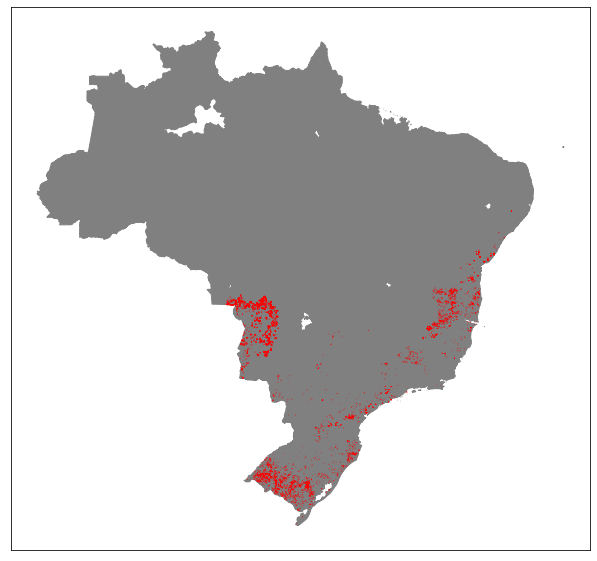

In [100]:
a = dados.plot(color='grey', edgecolor='grey', figsize=(20, 10))
biomas.plot(ax=a, color='red', edgecolor='red', figsize=(20, 10))
plt.xticks(())
plt.yticks(())
plt.show()

Colocando cores distintas para representar cada bioma:

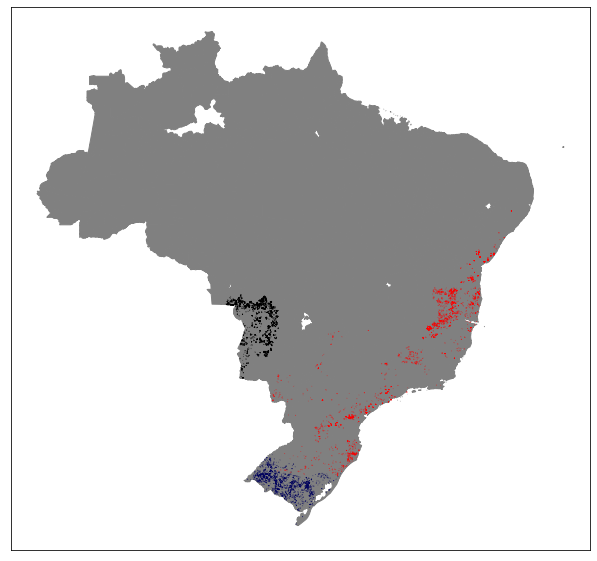

In [132]:
a = dados.plot(color='grey', edgecolor='grey', figsize=(20, 10))
b = biomas[biomas.bioma=='PAMPA'].plot(ax=a, color='#03045e', edgecolor='#03045e', figsize=(20, 10))
c = biomas[biomas.bioma=='PANTANAL'].plot(ax=b, color='black', edgecolor='black', figsize=(20, 10))
biomas[biomas.bioma=='MATA ATLANTICA'].plot(ax=c, color='red', edgecolor='red', figsize=(20, 10))
plt.xticks(())
plt.yticks(())
plt.show()
#azul = pampa
#preto = pantanal
#vermelho = mata atlantica (não tô conseguindo colocar legenda...)

Em primeiro momento, uma primeira possibilidade de análise seria verificar quais desses biomas têm maior área antropizada. Assim, utilizando a biblioteca `area` (<https://github.com/scisco/area>) para calcular esse dado (uma vez que existem dados faltantes no dataset):

In [155]:
from area import area

#pantanal
area_pantanal = 0
for item in pantanal_json: 
    area_pantanal += area(item['geometry']) #retorna area em m^2
area_pantanal = area_pantanal/1000 # km^2

#pampa
area_pampa = 0
for item in pampa_json: 
    area_pampa += area(item['geometry']) #retorna area em m^2
area_pampa = area_pampa/1000 # km^2

#mata atlantica
area_mata = 0
for item in mata_json: 
    area_mata += area(item['geometry']) #retorna area em m^2
area_mata = area_mata/1000 # km^2

print(f'Mata Atlântica: {area_mata} Km^2\nPantanal: {area_pantanal} Km^2\nPampa: {area_pampa} Km^2')

Mata Atlântica: 250027.53439163786 Km^2
Pantanal: 1123516.7672286325 Km^2
Pampa: 377920.92761727166 Km^2


Visualizando graficamente esses dados:

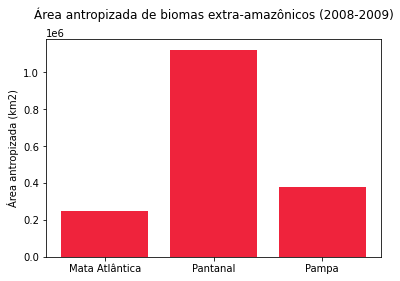

In [162]:
biom = ['Mata Atlântica', 'Pantanal', 'Pampa']
areas = [area_mata, area_pantanal, area_pampa]
plt.bar(biom, areas, color='#ef233c')
plt.ylabel('Área antropizada (km2)')
plt.title('Área antropizada de biomas extra-amazônicos (2008-2009)\n')
plt.show()

No gráfico acima, percebe-se que, dentre os biomas considerados, o pantanal era o com maior área antropizada entre 2008 e 2009, seguido pelo Pampa e pela Mata Atlântica.

### Extras

Além das análises feitas com relação aos dados dos biomas em si, foi possível, trabalhando com o geopandas, gerar outras visualizações interessantes do território brasileiro. Utilizando os metadados do banco, por exemplo, foi possível criar uma coluna referente a UF de cada município brasileiro e utilizar isso para plotar mapas específicos de cada estado.

In [186]:
dados['uf_code'] = dados['id'].map(str)
for i in range (0, dados['id'].size):
    dados.loc[i,'uf_code'] = int(dados['uf_code'].iloc[i][:2])
dados.head()

,id,name,description,geometry,uf_code
0,1100015,Alta Floresta D'Oeste,Alta Floresta D'Oeste,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",11
1,1100023,Ariquemes,Ariquemes,"POLYGON ((-62.53595 -9.73182, -62.50782 -9.754...",11
2,1100031,Cabixi,Cabixi,"POLYGON ((-60.39940 -13.45584, -60.40195 -13.4...",11
3,1100049,Cacoal,Cacoal,"POLYGON ((-61.00051 -11.39796, -61.01794 -11.4...",11
4,1100056,Cerejeiras,Cerejeiras,"POLYGON ((-61.50047 -13.00392, -61.47901 -13.0...",11


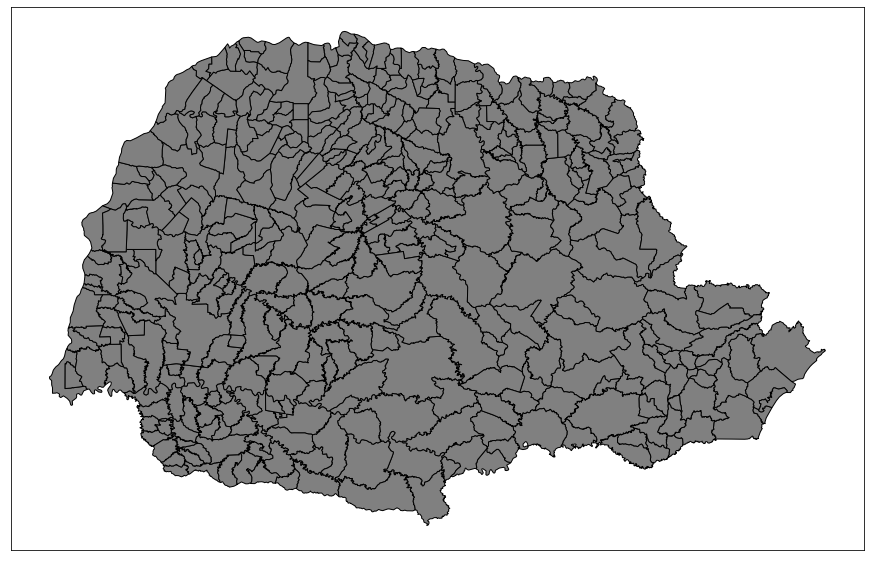

In [201]:
estado = "Paraná" #Basta alterar o estado para visualizar o mapa de seus municípios
uf = estados[estados.name == estado]['value'].values[0]
a = dados[dados.uf_code == uf].plot(color='grey', edgecolor='black', figsize=(20, 10))
plt.xticks(())
plt.yticks(())
plt.show()

Utilizando uma outra base de dados com a estimativa das populações de cada município em 2009 (ano dos dados dos biomas), que pode ser acessada em: <https://www.ibge.gov.br/estatisticas/downloads-estatisticas.html>, foi possível fazer mais algumas visualizações.

In [191]:
populacao = pd.read_csv('UF_Municipio.csv', sep = ';', encoding = 'utf8')
populacao_por_estado = pd.read_csv('UF_populacoes.csv', sep = ';', encoding = 'utf8')

In [192]:
populacao_por_estado = populacao_por_estado.rename(columns={'regiao': 'name'})

In [195]:
import numpy as np

estados.head()
populacao_por_estado['value'] = ''
np.array(populacao_por_estado['name']).tolist()
lista = [x.lstrip() for x in np.array(populacao_por_estado['name']).tolist()]
populacao_por_estado.loc[0,'name']

'    Rondônia'

In [196]:
pop = populacao.drop(columns=['Unnamed: 5'])
pop.head()

,uf,cod_uf,cod,name,populacao
0,RO,11,15,Alta Floresta D'Oeste,24354
1,RO,11,379,Alto Alegre dos Parecis,11875
2,RO,11,403,Alto Paraíso,17569
3,RO,11,346,Alvorada D'Oeste,17127
4,RO,11,23,Ariquemes,85541


In [ ]:
dados_pop = dados.merge(pop, how='left', on='name')

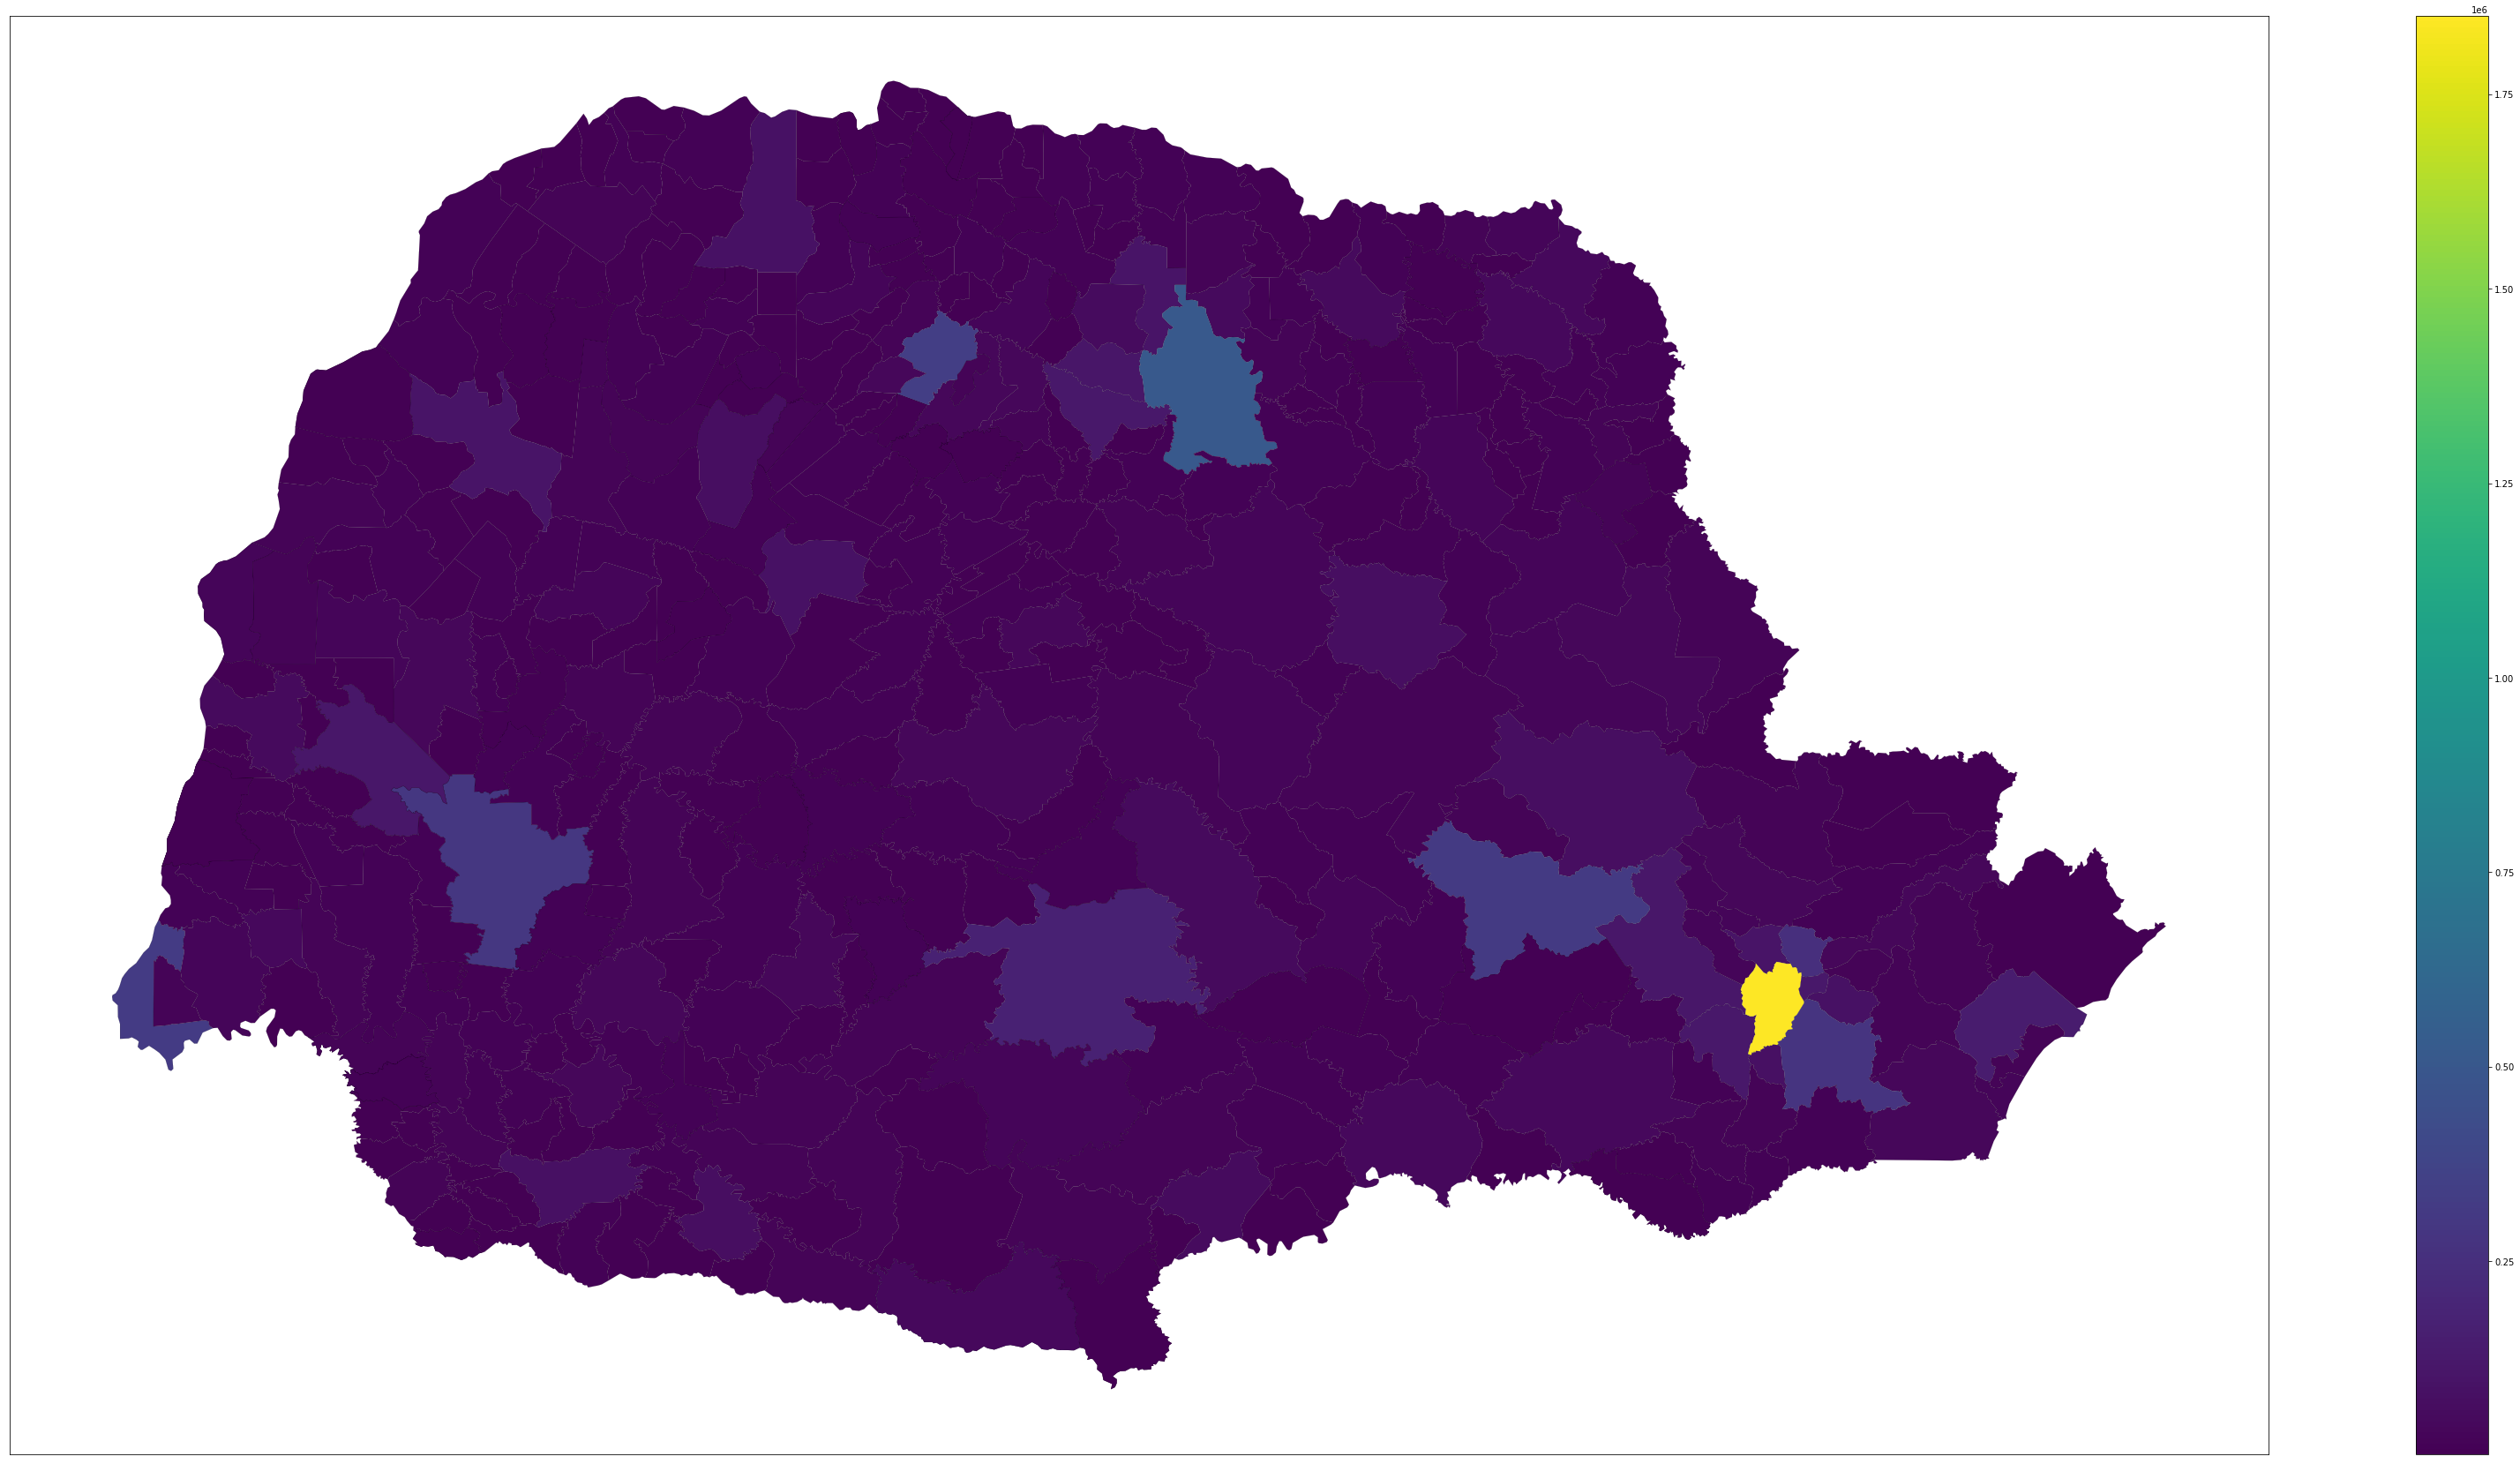

In [208]:
# Choropleth map da população dos municípios de algum estado escolhido
estado = 'Paraná' #basta alterar o valor para escolher o mapa a ser visualizado
uf = estados[estados.name == estado]['value'].values[0]
estado_pop = dados_pop[dados_pop['uf_code'] == uf]
estado_pop.plot(column = 'populacao', 
               legend = True, 
               figsize = (60,30),
               edgecolor='black',
               cmap = 'viridis',
               linewidth = 0.1) 
plt.xticks(())
plt.yticks(())
plt.show()

### Conclusão

Apesar de ter sido possível extrair algumas análises dos dados considerados, faz-se perceptível que a relevância dos mesmos é pequena, tendo em vista a data (entre os anos de 2008 e 2009, mais de uma década atrás), as poucas informações fornecidas pelos autores com relação ao que os dados representam (não ficou claro se tratava do avanço da antropização ao longo dos anos considerados, da extensão geral da ação humana sobre esses biomas, ou mesmo sua área restante) e a ocorrência de dados faltantes (para as áreas, por exemplo). Nesse sentido, devido às limitações dos dados, poderia ser relevante expandir essa primeira análise para uma mais completa e relevante, considerando a série histórica desse processo e projetando possíveis cenários futuros. Contudo, como não conseguimos encontrar outras bases que complementassem esses dados, acabou não sendo possível avançar com as análises nesse sentido.

Ainda assim, este trabalho proporcionou uma importante curva de aprendizado com relação ao uso do MongoDB, de arquivos `.geojson` e da biblioteca geopandas. Mesmo que as análises realizadas não tenham sido tão complexas devido à limitação da base de dados escolhida, essas ferramentas se mostraram muito úteis para a realização de análises de dados geográficos. 